<img src="pds_banner.png" style="height:200px">


# Laboratorio 7 Procesamiento de señales 2019-1

# Sistemas DTMF

## Universidad de Antioquia

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 3. Sistemas DTMF (Dual-tone multi-frequency)


[Que es el DTMF](https://es.qwe.wiki/wiki/Dual-tone_multi-frequency_signaling)

Los sistemas DTMF es la forma como los teléfonos análogos envían el número marcado por un usuario a la oficina central. Esta fue la forma más utilizada antes de las redes digitales, pero aun es usado en call centers para selección de opciones (marque 4 para hablar con un asesor).

Cada vez que contactas al sistema automatizado de una compañía, las selecciones que haces envían tonos DTMF a los sistemas de cómputo de la compañía para que sean interpretados. El correo de voz, centros de asistencia y la banca telefónica están entre los muchos sistemas automatizados que responden a señales DTMF.

El mecanismo es sencillo, pero inteligente. El teclado del teléfono consiste en una malla de $4\times3$, donde cada botón se asocia a dos frecuencias, de acuerdo con la siguiente tabla.

|        | 1209 Hz | 1336 Hz | 1477 Hz |
|--------|---------|---------|---------|
| 697 Hz | 1       | 2       | 3       |
| 770 Hz | 4       | 5       | 6       |
| 852 Hz | 7       | 8       | 9       |
| 941 Hz | *       | 0       | #       |


Las frecuencias en la tabla tienen la propiedad de que ninguna es un multiplo de cualquier otra, lo cual reduce la probabilidad de detectar errores en la transmisión de los tonos. Cuando un botón es presionado, las dos frecuencias son generadas de forma simultanea, y son enviadas por el canal telefónico. Por ejemplo, si se presiona '1', la señal generada será

$$x(t)=\sin(2\pi*1209*t)+\sin(2\pi*697*t)$$.

Las especificaciones del estandar DTMF sugieren que:


1. Cada tono debe tener una duración de al menos 65ms
2. Los tonos correspondientes a digitos consecutivos deben estar separados por un silencio de 65ms de duración.

En esta sección se construirá un detector DTMF basado en la transformada discreta de Fourier. El primer paso es construir un codificador, el cual se obtiene usando la siguiente función.

In [1]:
def dtmf_dial(number, FS):
    DTMF = {
        '1': (697, 1209), '2': (697, 1336), '3': (697, 1477),
        '4': (770, 1209), '5': (770, 1336), '6': (770, 1477),
        '7': (852, 1209), '8': (852, 1336), '9': (852, 1477),
        '*': (941, 1209), '0': (941, 1336), '#': (941, 1477),        
    }
    MARK = 0.1
    SPACE = 0.1
    n = np.arange(0, int(MARK * FS))
    x = np.array([])
    for d in number:
        s = np.sin(2*np.pi * DTMF[d][0] / FS * n) + np.sin(2*np.pi * DTMF[d][1] / FS * n) 
        x = np.concatenate((x, s, np.zeros(int(SPACE * FS))))
    return x

#

Donde number es una cadena de caracterires ('123456789'), el cual a partir de una secuencia de botones marcados genera la secuencia de señales a transmitir.

<span style="color:red">1. Defina una frecuencia de muestreo de 8000\,Hz para generar las señales.</span>

<span style="color:red">2. Utilice el número de su cédula para generar la señal a transmitir por el canal telefónico</span>

<span style="color:red">3. Escuche y grafique la señal obtenida</span>

<span style="color:red">4. ¿Cómo construiría usted el decodificador que a partir de la señal en el tiempo retorne el número marcado?</span>


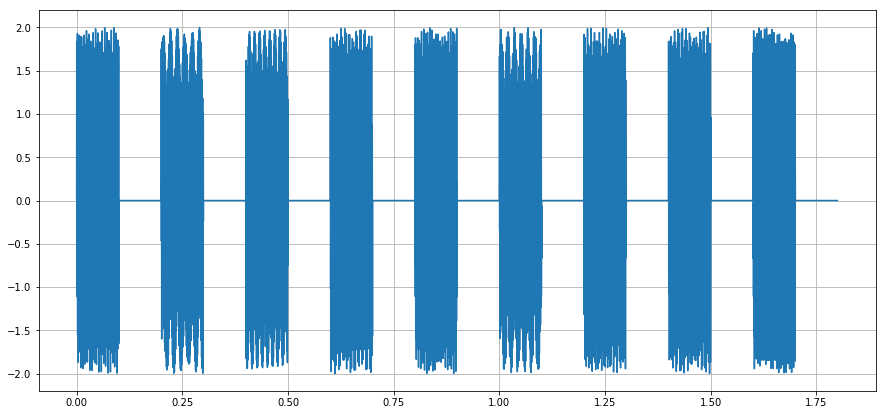

In [54]:
fs=8000
numero="123456789"

x=dtmf_dial(numero, fs)

t=np.arange(0,len(x)/fs, 1/fs)

plt.figure(figsize=(15,7))
plt.plot(t,x)
plt.grid()
plt.show()

from IPython.display import Audio

Audio(x,rate=fs)

El primer paso para construir el detector consiste en separar la señal en los segmentos donde cada número fue marcado. Para esto se puede usar la energía calculada en segmentos cortos de tiempo, y mediante un umbral tomar la decisión.

<span style="color:red"> 5. Separe la señal en segmentos de 240 muestras. Calcule la energía para cada segmento, y grafique el contorno de energía obtenido para la señal. Construya una función que reciba la señal y retorne el contorno de energía (recuerde el laboratorio 0). Será util en los siguientes puntos.</span>


<span style="color:red">6. Complete la siguiente función para separar la señal en los segmentos donde cada número fue marcado.</span>

In [69]:

def energy(x):
    init=0
    fin=240
    E=[]
    while fin<len(x):
        segmento=x[init:fin]
        segment2=segmento**2
        ene=np.sum(segment2)
        E.append(ene)
        init+=240
        fin+=240
    we=np.asarray(E)
    plt.plot(we)
    plt.show()
    return we



def dtmf_split(x, win=240, th=500):
    edges = []
    
    we=energy(x)
    L = len(we)
    
    ix = 0
    while ix < L:
        while ix < L and we[ix] < th:
            ix = ix+1
        if ix >= L:
            break    # ending on silence
        iy = ix
        while iy < L and we[iy] > th:
            iy = iy+1
        edges.append((ix * win, iy * win))
        ix = iy
    
    return edges

<span style="color:red">7. Verifique el funcionamiento de la función.</span>

<span style="color:red"> 8. Calcule la transformada de Fourier para algunos de los números marcados en la señal de prueba. ¿Qué diferencia se observa en cada número?</span>

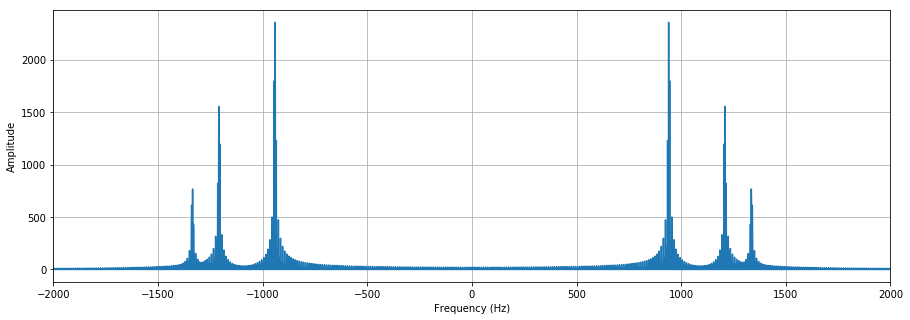

In [65]:
numero="****00"

x1=dtmf_dial(numero, fs)

X1=np.fft.fft(x1)
freq=np.fft.fftfreq(len(X1), d=1/fs)
plt.figure(figsize=(15,5))
plt.plot(freq, np.abs(X1))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim([-2000,2000])
plt.grid()
plt.show()

<span style="color:red"> 9. Utilice la siguiente función para detectar la secuencia de botones marcados a partir de la señal utilizada.</span>

In [66]:
def dtmf_decode(x, FS, edges = None):
    # the DTMF frequencies
    LO_FREQS = np.array([697.0, 770.0, 852.0, 941.0])
    HI_FREQS = np.array([1209.0, 1336.0, 1477.0])

    KEYS = [['1', '2', '3'], ['4', '5', '6'], ['7', '8', '9'], ['*', '0', '#']]
    
    # frequency ranges to search for low and high DTMF tones
    LO_RANGE = (680.0, 960.0)
    HI_RANGE = (1180.0, 1500.0)

    number = []
    
    # now examine each tone in turn. the freqency mapping on the DFT
    #  axis will be dependent on the length of the data vector
    if edges is None:
        edges = dtmf_split(x)
    for g in edges:
        # compute the DFT of the tone segment
        X = abs(np.fft.fft((x[g[0]:g[1]])))
        N = len(X)
        # compute the resolution in Hz of a DFT bin
        res = float(FS) / N
        
        # find the peak location within the low freq range
        a = int(LO_RANGE[0] / res)
        b = int(LO_RANGE[1] / res)
        lo = a + np.argmax(X[a:b])
        # find the peak location within the high freq range
        a = int(HI_RANGE[0] / res)
        b = int(HI_RANGE[1] / res)
        hi = a + np.argmax(X[a:b])
      
        # now match the results to the DTMF frequencies
        row = np.argmin(abs(LO_FREQS - lo * res))
        col = np.argmin(abs(HI_FREQS - hi * res))

        # and finally convert that to the pressed key
        number.append(KEYS[row][col])
    return number

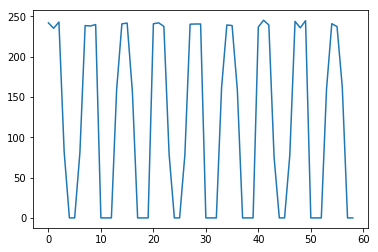

[]


In [67]:
num_marcado=dtmf_decode(x, 8000)
print(num_marcado)

<span style="color:red"> 10. Qué problemas puede tener la función anterior para detectar correctamente los números marcados? </span>

<span style="color:red"> 11. Considere la siguiente señal de prueba</span>

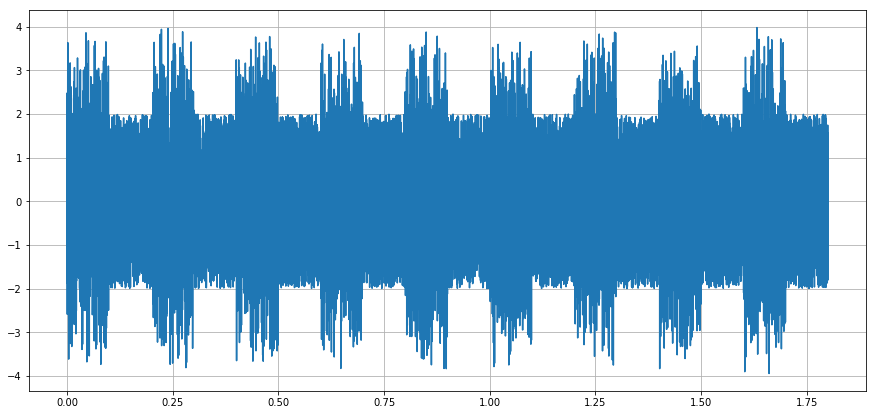

In [62]:
noisy = x + np.random.uniform(-2, 2, len(x))

t=np.arange(0,len(x)/fs, 1/fs)

plt.figure(figsize=(15,7))
plt.plot(t,noisy)
plt.grid()
plt.show()

Audio(noisy, rate=8000)

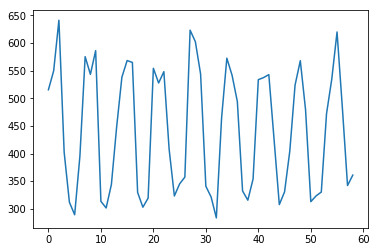

['1', '2', '3', '4', '5', '6', '7', '8', '9']


In [70]:
num_marcado=dtmf_decode(noisy, 8000)
print(num_marcado)

<span style="color:red"> 12. Detecte la secuencia de botones macados a partir de la señal. </span>

<span style="color:red"> 13. ¿Como se puede corregir el problema? </span>

<span style="color:red"> 14. Corrija el problema en la detección, y detecte nuevamente las teclas introducidas por la persona. </span>